In [ ]:
%matplotlib inline


Transfer Learning for Computer Vision Tutorial
==============================================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at `cs231n notes <https://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [2]:
# !wget https://lp-prod-resources.s3-us-west-2.amazonaws.com/other/Deploying+a+Deep+Learning+Model+on+Web+and+Mobile+Applications+Using+TensorFlow/Food+101+-+Data+Subset.zip -P data


In [3]:
#!unzip -q data/Food+101+-+Data+Subset.zip -d data/


In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/food-101-subset/images'



image_dataset = datasets.ImageFolder(data_dir,transform=data_transforms['train'])

dataset_size = len(image_dataset)

train_size = int(dataset_size * 0.8)
validation_size =  dataset_size -train_size


train_dataset, val_dataset = torch.utils.data.random_split(image_dataset, (train_size, validation_size))


dataloaders = {}
dataloaders['train'] = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=16,
                                             num_workers=4)
dataloaders['val'] = torch.utils.data.DataLoader(dataset=val_dataset, shuffle=False, batch_size=16,
                                             num_workers=4)


print("Length of the train_loader:", len(dataloaders['train']))
print("Length of the val_loader:", len(dataloaders['val']))


dataset_sizes = { 'train': train_size , 'val': validation_size}
class_names = image_dataset.classes
print (class_names,dataset_sizes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Length of the train_loader: 150
Length of the val_loader: 38
['apple_pie', 'caesar_salad', 'falafel'] {'train': 2400, 'val': 600}


Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



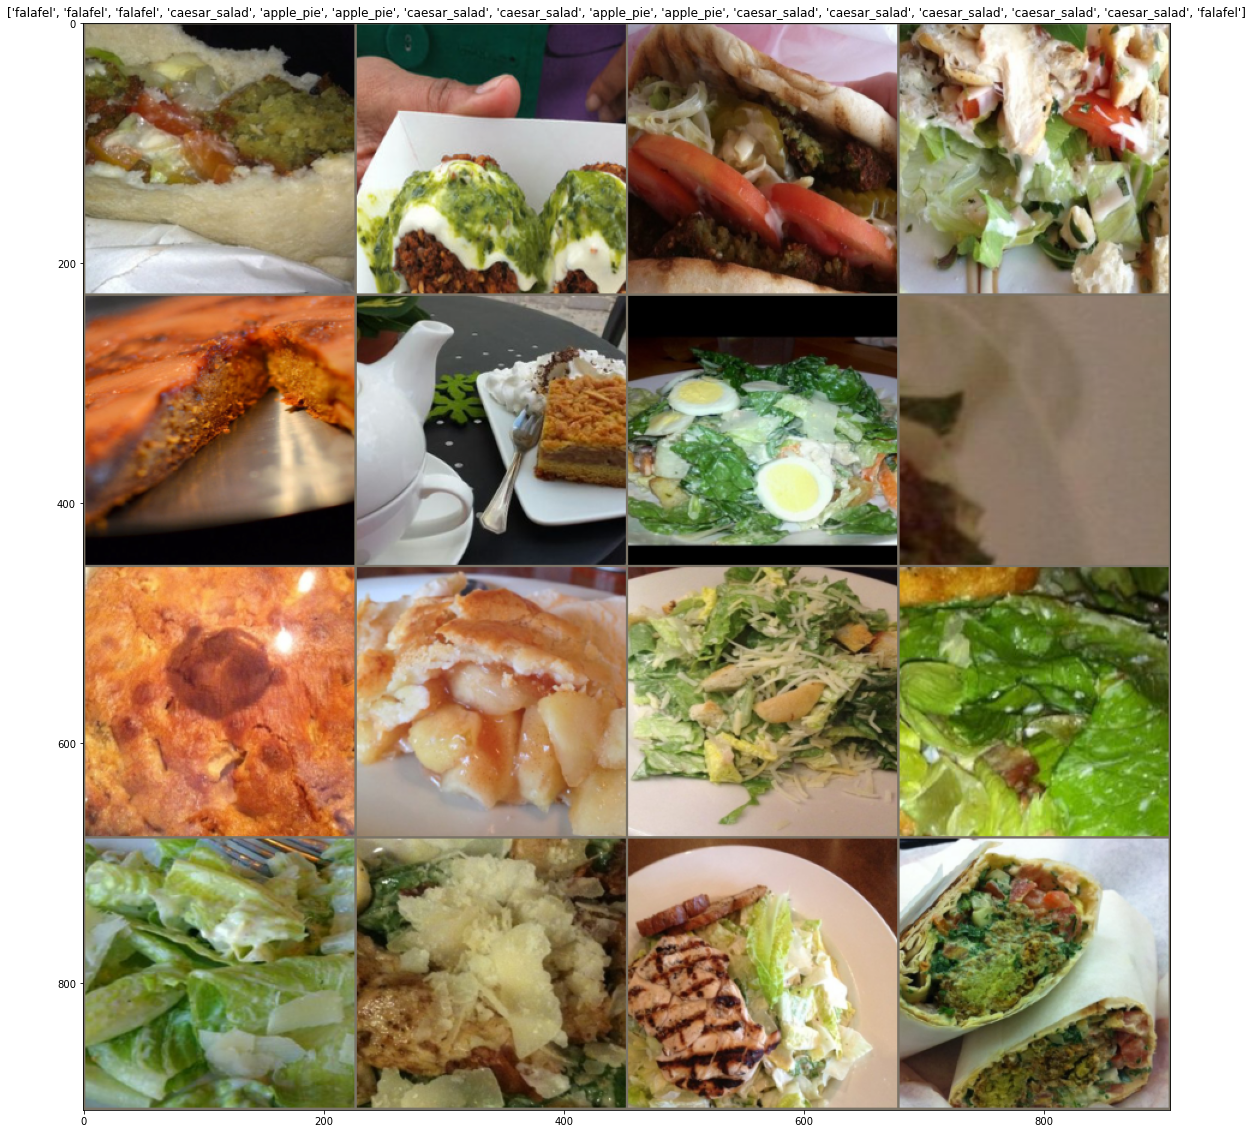

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs,nrow=4)
plt.figure(figsize=[20, 20])

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [8]:
model_ft = models.mobilenet_v2(pretrained=True)
model_ft

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [9]:
#model_ft = models.resnet18(pretrained=True)
#num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
#model_ft.fc = nn.Linear(num_ftrs, 2)


model_ft = models.mobilenet_v2(pretrained=True)
num_ftrs = model_ft.classifier[-1].in_features
model_ft.classifier[-1] = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [10]:
num_epochs=25

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=num_epochs
                       )

Epoch 0/24
----------
train Loss: 0.4947 Acc: 0.7913
val Loss: 0.2779 Acc: 0.9000

Epoch 1/24
----------
train Loss: 0.3078 Acc: 0.8863
val Loss: 0.2481 Acc: 0.9183

Epoch 2/24
----------
train Loss: 0.2832 Acc: 0.8958
val Loss: 0.2441 Acc: 0.9000

Epoch 3/24
----------
train Loss: 0.2441 Acc: 0.9063
val Loss: 0.2067 Acc: 0.9300

Epoch 4/24
----------
train Loss: 0.2399 Acc: 0.9100
val Loss: 0.2355 Acc: 0.9050

Epoch 5/24
----------
train Loss: 0.2081 Acc: 0.9229
val Loss: 0.1954 Acc: 0.9267

Epoch 6/24
----------
train Loss: 0.1969 Acc: 0.9242
val Loss: 0.2385 Acc: 0.9183

Epoch 7/24
----------
train Loss: 0.1753 Acc: 0.9379
val Loss: 0.1990 Acc: 0.9267

Epoch 8/24
----------
train Loss: 0.1627 Acc: 0.9396
val Loss: 0.2008 Acc: 0.9250

Epoch 9/24
----------
train Loss: 0.1408 Acc: 0.9496
val Loss: 0.1913 Acc: 0.9283

Epoch 10/24
----------
train Loss: 0.1242 Acc: 0.9529
val Loss: 0.2127 Acc: 0.9217

Epoch 11/24
----------
train Loss: 0.1225 Acc: 0.9558
val Loss: 0.1940 Acc: 0.9350

Ep

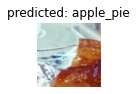

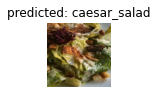

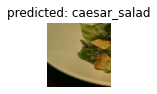

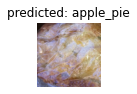

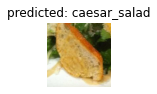

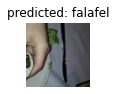

In [11]:
visualize_model(model_ft)

Further Learning
-----------------

If you would like to learn more about the applications of transfer learning,
checkout our `Quantized Transfer Learning for Computer Vision Tutorial <https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html>`_.





In [12]:
class_names

['apple_pie', 'caesar_salad', 'falafel']

In [13]:
model_ft

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [14]:
save_path = "artifacts/model_food_small.pt"

In [15]:
torch.save(model_ft, save_path)


In [16]:
model_cpu = torch.load(save_path)
model_cpu = model_cpu.to('cpu')
model_cpu.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [17]:
def predict_image(image_path:str):
    img = Image.open(image_path)

    img_t = data_transforms['val'](img)

    batch_t = torch.unsqueeze(img_t, 0)

    out = model_cpu(batch_t)


    _, indices = torch.sort(out, descending=True)

    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100

    res = [(class_names[idx], percentage[idx].item()) for idx in indices[0][:5] ]
         
    return res

In [18]:
predict_image('data/food-101-subset/images/caesar_salad/137024.jpg')

[('caesar_salad', 94.28158569335938),
 ('falafel', 5.67999267578125),
 ('apple_pie', 0.038414910435676575)]

In [19]:
predict_image('data/food-101-subset/images/falafel/1016116.jpg')

[('falafel', 99.99982452392578),
 ('caesar_salad', 0.00010253919754177332),
 ('apple_pie', 8.039786189328879e-05)]

In [20]:
predict_image('data/food-101-subset/images/apple_pie/1050519.jpg')

[('apple_pie', 83.6741943359375),
 ('falafel', 15.933582305908203),
 ('caesar_salad', 0.39222463965415955)]

In [21]:
class_names

['apple_pie', 'caesar_salad', 'falafel']